# Rollout Baseline

在使用 baseline 时，历史的网络参数将被保留。每个训练周期（epoch）结束后，会使用当前网络参数在 10,000 个测试案例上进行测试。如果经过配对 t 检验（paired t-test）后，训练后的网络参数显著优于 baseline 网络参数（显著性水平 $\alpha = 5\%$），则用当前网络参数替换 baseline 网络的参数。

**注意**：使用 baseline 网络时，每次选择概率最大的动作，以减少方差的影响。

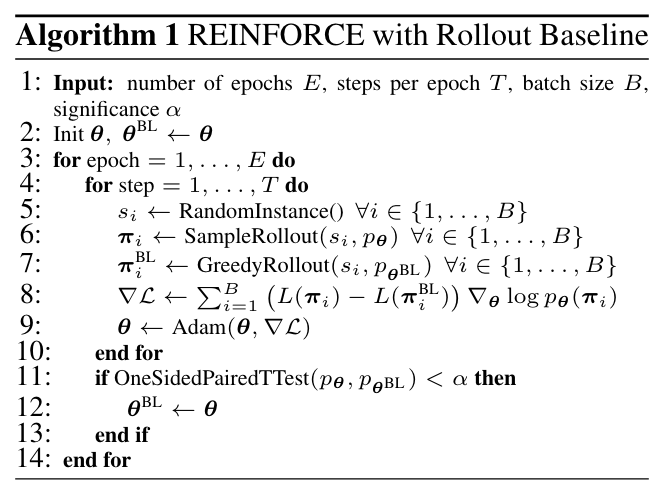

In [1]:
# 导入库
import os
import math
import argparse
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
# 定义TSPDataset类
class TSPDataset(Dataset):
    def __init__(self, num_nodes, num_samples, random_seed=42):
        super().__init__()
        
        self.num_nodes = num_nodes
        self.num_samples = num_samples
        self.random_seed = random_seed
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        seed = self.random_seed + idx
        generator = torch.Generator().manual_seed(seed)
        sample = torch.rand(self.num_nodes, 2, generator=generator)
        return sample

In [3]:
# 定义reward函数
def reward(sols):
    # sols: (batch_size, seq_len, input_size)
    # lengths: (batch_size,)
    lengths = torch.norm(sols[:, 1:, :] - sols[:, :-1, :], dim=2).sum(dim=1)
    lengths += torch.norm(sols[:, -1, :] - sols[:, 0, :], dim=1)
    return lengths

In [4]:
# 定义ResidualConnection类
class ResidualConnection(nn.Module):
    def __init__(self, module):
        super().__init__()
        
        self.module = module
    
    def forward(self, x):
        return x + self.module(x)

In [5]:
# 定义Normalization类
class Normalization(nn.Module):
    def __init__(self, embedding_size, normalization='batch'):
        super().__init__()
        
        normalizer = {
            'batch': nn.BatchNorm1d,
            'instance': nn.InstanceNorm1d,
        }.get(normalization, None)
        assert normalizer is not None, f'Unsupported normalization type: {normalization}'
        
        self.normalizer = normalizer(embedding_size, affine=True)
        
        self._init_parameters()
        
    def _init_parameters(self):
        if hasattr(self.normalizer, 'weight') and self.normalizer.weight is not None:
            nn.init.uniform_(self.normalizer.weight, 0., 1.)
        if hasattr(self.normalizer, 'bias') and self.normalizer.bias is not None:
            nn.init.zeros_(self.normalizer.bias)
            
    def forward(self, x):
        if isinstance(self.normalizer, nn.BatchNorm1d):
            return self.normalizer(x.view(-1, x.size(-1))).view(*x.size())
        else:
            return self.normalizer(x.permute(0, 2, 1)).permute(0, 2, 1)

In [6]:
# 定义MultiHeadAttention类
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, query_size, key_size, value_size, embedding_size, dropout=0.1):
        super().__init__()
        assert embedding_size % num_heads == 0
        
        self.num_heads = num_heads
        self.embedding_size = embedding_size
        self.head_size = embedding_size // num_heads
        
        self.W_q = nn.Linear(query_size, embedding_size)
        self.W_k = nn.Linear(key_size, embedding_size)
        self.W_v = nn.Linear(value_size, embedding_size)
        self.W_o = nn.Linear(embedding_size, embedding_size)
        self.dropout = nn.Dropout(dropout)
        
        self.scale_factor = math.sqrt(self.head_size)
        
        self._init_parameters()
        
    def _init_parameters(self):
        for param in self.parameters():
            std = 1. / math.sqrt(param.size(-1))
            param.data.uniform_(-std, std)
        
    def forward(self, q, k=None, v=None, mask=None):
        # q: (batch_size, q_len, query_size)
        # k: (batch_size, seq_len, key_size)
        # v: (batch_size, seq_len, value_size)
        # mask: (batch_size, seq_len)
        if k is None:
            k = q
            v = q
        q_len = q.size(1)
        batch_size, seq_len, _ = k.size()
        
        # Q: (batch_size, q_len, embedding_size)
        Q = self.W_q(q)
        # K, V: (batch_size, seq_len, embedding_size)
        K = self.W_k(k)
        V = self.W_v(v)
        
        # Q: (batch_size, num_heads, q_len, head_size)
        Q = Q.view(batch_size, q_len, self.num_heads, self.head_size).transpose(1, 2)
        # K, V: (batch_size, num_heads, seq_len, head_size)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_size).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_size).transpose(1, 2)
        
        # attn_scores: (batch_size, num_heads, q_len, seq_len)
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale_factor
        if mask is not None:
            # mask: (batch_size, num_heads, q_len, seq_len)
            mask = mask.unsqueeze(1).unsqueeze(1).expand(-1, self.num_heads, q_len, -1)
            mask_clone = mask.clone().bool()
            attn_scores = attn_scores.masked_fill(mask_clone, float('-inf'))
            
        # attn_weights: (batch_size, num_heads, q_len, seq_len)
        attn_weights = F.softmax(attn_scores, -1)
        attn_weights = self.dropout(attn_weights)
        
        # attn_output: (batch_size, num_heads, q_len, head_size)
        attn_output = torch.matmul(attn_weights, V)
        # attn_output: (batch_size, q_len, embedding_size)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, q_len, self.embedding_size)
        
        # output: (batch_size, q_len, embedding_size)
        output = self.W_o(attn_output)
        
        return output

In [7]:
# 定义MultiHeadAttentionLayer类
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, num_heads, embedding_size, FF_hidden_size=512, normalization='batch', dropout=0.1):
        super().__init__()
        
        self.attention = ResidualConnection(
            MultiHeadAttention(num_heads, embedding_size, embedding_size, embedding_size, embedding_size, dropout)
        )
        self.norm1 = Normalization(embedding_size, normalization)
        
        self.feed_forward = ResidualConnection(
            nn.Sequential(
                nn.Linear(embedding_size, FF_hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(FF_hidden_size, embedding_size),
            ) if FF_hidden_size > 0 else nn.Linear(embedding_size, embedding_size)
        )
        self.norm2 = Normalization(embedding_size, normalization)
        
    def forward(self, x):
        x = self.norm1(self.attention(x))
        x = self.norm2(self.feed_forward(x))
        return x

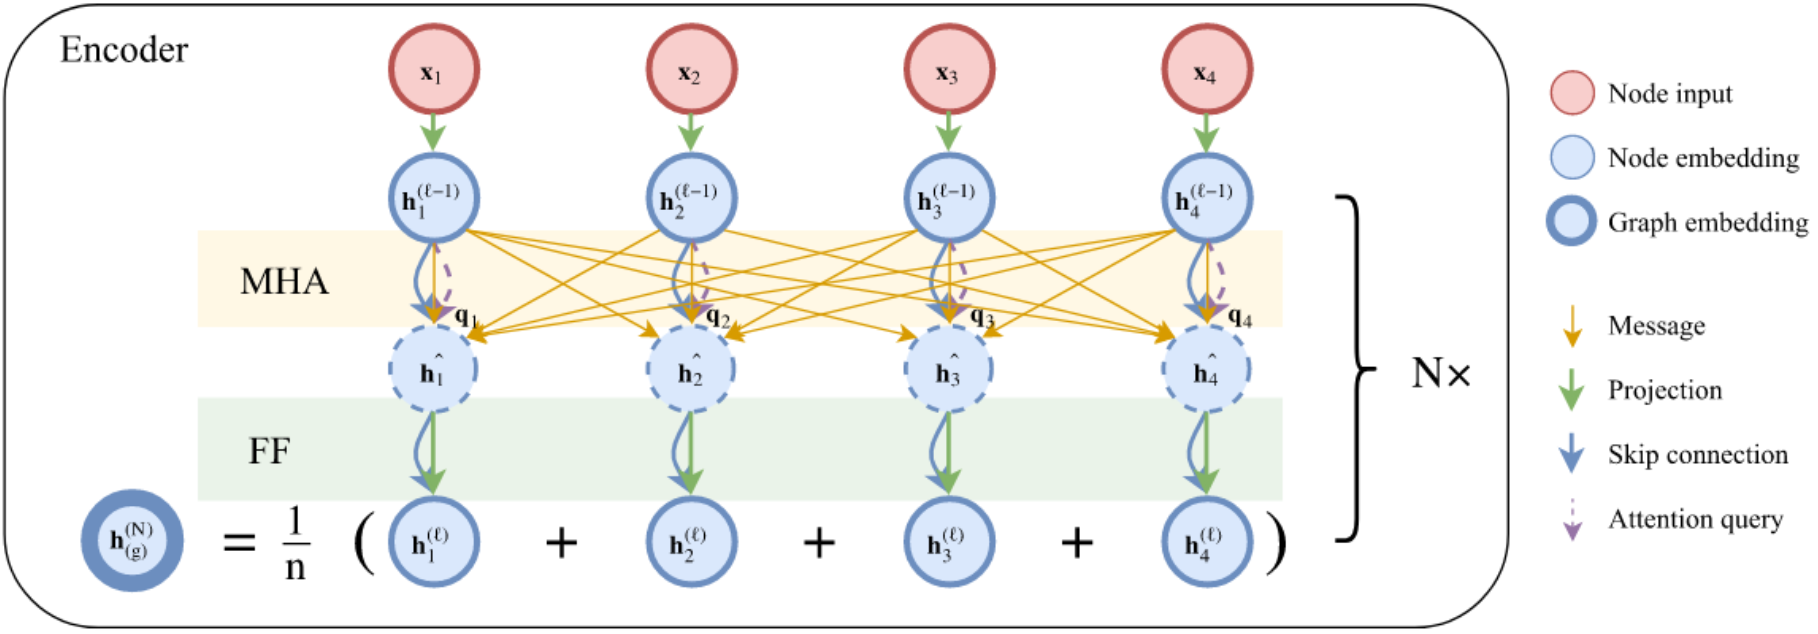

In [8]:
# 定义Encoder类
class Encoder(nn.Module):
    def __init__(self, num_heads, embedding_size, num_layers, input_size=None, FF_hidden_size=512, normalization='batch', dropout=0.1):
        super().__init__()
        
        self.embedding = nn.Linear(input_size, embedding_size) if input_size is not None else None
        self.layers = nn.Sequential(*(
            MultiHeadAttentionLayer(num_heads, embedding_size, FF_hidden_size, normalization, dropout)
            for _ in range(num_layers)
        ))
        
    def forward(self, inputs):
        # inputs: (batch_size, seq_len, input_size)
        if self.embedding is not None:
            # embedded: (batch_size, seq_len, embedding_size)
            embedded = self.embedding(inputs)
        else:
            embedded = inputs
        # node_embedding: (batch_size, seq_len, embedding_size)
        node_embedding = self.layers(embedded)
        return node_embedding

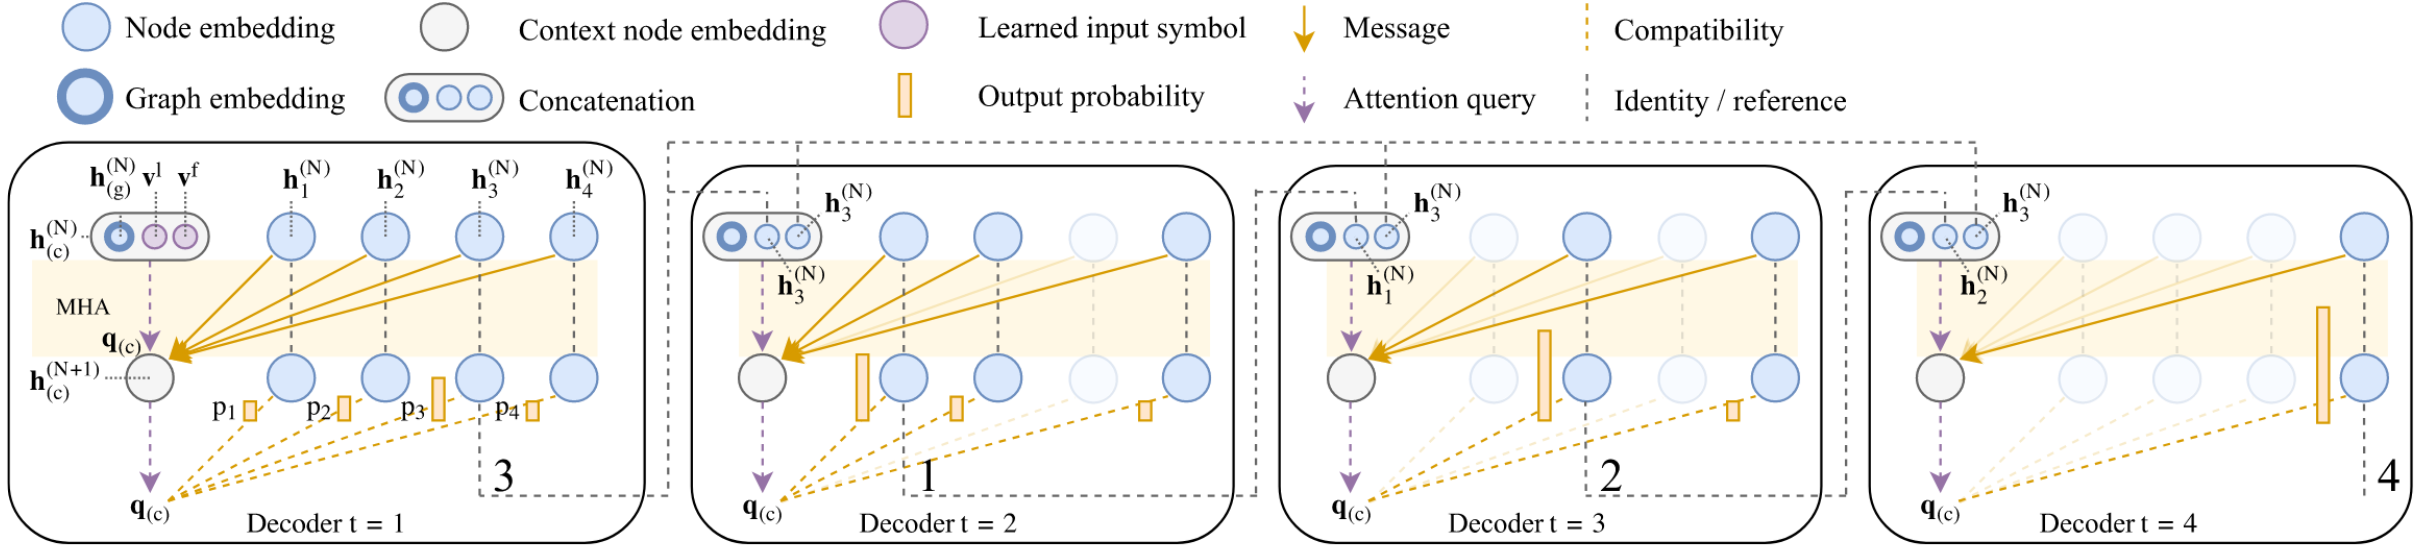

In [9]:
# 定义Decoder类
class Decoder(nn.Module):
    def __init__(self, num_heads, embedding_size, C=10, dropout=0.1, temperature=None, argmax=False):
        super().__init__()
        assert embedding_size % num_heads == 0
        
        self.num_heads = num_heads
        self.embedding_size = embedding_size
        self.C = C
        self.temperature = temperature
        self.argmax = argmax
        
        self.input_placeholder = nn.Parameter(torch.zeros(2 * embedding_size))
        
        self.multihead_attention = MultiHeadAttention(num_heads, 3 * embedding_size, embedding_size, embedding_size, embedding_size, dropout)
        
        self.W_q = nn.Linear(embedding_size, embedding_size)
        self.W_k = nn.Linear(embedding_size, embedding_size)
        self.scale_factor = math.sqrt(embedding_size)
        
        self._init_parameters()
        
    def _init_parameters(self):
        for param in self.parameters():
            std = 1. / math.sqrt(param.size(-1))
            param.data.uniform_(-std, std)
    
    def forward(self, node_embedding):
        # node_embedding: (batch_size, seq_len, embedding_size)
        batch_size, seq_len, embedding_size = node_embedding.size()
        assert self.embedding_size == embedding_size
        
        # graph_embedding: (batch_size, embedding_size)
        graph_embedding = node_embedding.mean(dim=1)
        
        # mask: (batch_size, seq_len)
        mask = torch.zeros(batch_size, seq_len, dtype=torch.bool, device=node_embedding.device)
        
        idxs = None
        first_node_context, current_node_context = None, None
        prev_probs, prev_idxs = [], []
        
        for _ in range(seq_len):
            if first_node_context is None:
                # context_embedding: (batch_size, 3 * embedding_size)
                context_embedding = torch.cat((graph_embedding, self.input_placeholder.unsqueeze(0).expand(batch_size, -1)), dim=1)
            else:
                # context_embedding: (batch_size, 3 * embedding_size)
                context_embedding = torch.cat((graph_embedding, current_node_context, first_node_context), dim=1)
                
            # attn_output: (batch_size, embedding_size)
            attn_output = self.multihead_attention(context_embedding.unsqueeze(1), node_embedding, node_embedding, mask).squeeze(1)
            
            # query: (batch_size, embedding_size)
            query = self.W_q(attn_output)
            # key: (batch_size, seq_len, embedding_size)
            key = self.W_k(node_embedding)
            
            # logits: (batch_size, seq_len)
            logits = torch.matmul(query.unsqueeze(1), key.transpose(-2, -1)).squeeze(1) / self.scale_factor
            logits = self.C * torch.tanh(logits)
            mask_clone = mask.clone().bool()
            logits = logits.masked_fill(mask_clone, float('-inf'))
            
            # probs: (batch_size, seq_len)
            probs = F.softmax(logits, dim=-1) if self.temperature is None else F.softmax(logits / self.temperature, dim=-1)
            # idxs: (batch_size,)
            if self.argmax:
                idxs = torch.argmax(probs, 1)
            else:
                idxs = torch.multinomial(probs, 1).squeeze(1)
            mask[torch.arange(batch_size), idxs] = True
            
            
            prev_probs.append(probs[torch.arange(batch_size), idxs])
            prev_idxs.append(idxs)
            
            # current_node_context: (batch_size, embedding_size)
            current_node_context = node_embedding[torch.arange(batch_size), idxs, :]
            if first_node_context is None:
                first_node_context = current_node_context
                
        # prev_probs, prev_idxs: (batch_size, seq_len)
        prev_probs = torch.stack(prev_probs, dim=1)
        prev_idxs = torch.stack(prev_idxs, dim=1)
        return prev_probs, prev_idxs

In [10]:
# 定义Actor类
class Actor(nn.Module):
    def __init__(self, num_heads, embedding_size, num_layers, input_size, FF_hidden_size, normalization, dropout, C, temperature, argmax, reward):
        super().__init__()
        
        self.reward = reward
        
        self.encoder = Encoder(num_heads, embedding_size, num_layers, input_size, FF_hidden_size, normalization, dropout)
        self.decoder = Decoder(num_heads, embedding_size, C, dropout, temperature, argmax)
        
    def forward(self, inputs):
        # inputs: (batch_size, seq_len, input_size)
        # node_embedding: (batch_size, seq_len, input_size)
        node_embedding = self.encoder(inputs)
        # probs, idxs: (batch_size, seq_len)
        probs, idxs = self.decoder(node_embedding)
        # actions: (batch_size, seq_len, input_size)
        actions = inputs[torch.arange(inputs.size(0)).unsqueeze(1), idxs]
        # rewards: (batch_size,)
        rewards = self.reward(actions)
        return rewards, idxs, probs

In [11]:
# 训练
def train(args, train_dataset, val_dataset, baseline_dataset):
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)
    baseline_loader = DataLoader(baseline_dataset, batch_size=args.batch_size, shuffle=False)
    
    actor = Actor(args.num_heads, args.embedding_size, args.num_layers, args.input_size, args.FF_hidden_size, args.normalization, args.dropout, args.C, args.temperature, False, reward).to(args.device)
    baseline_network = Actor(args.num_heads, args.embedding_size, args.num_layers, args.input_size, args.FF_hidden_size, args.normalization, args.dropout, args.C, args.temperature, True, reward).to(args.device)
    baseline_network.load_state_dict(actor.state_dict())
    baseline_network.eval()
    optimizer = optim.Adam(actor.parameters(), lr=args.lr)
    
    step = 0
    best_length = float('inf')
    train_lengths, val_lengths = [], []
    writer = SummaryWriter()
    model_path = os.path.join(args.output_dir, args.name)
    
    for epoch in range(args.n_epochs):
        for batch_id, train_batch in enumerate(train_loader):
            actor.train()
            
            # inputs: (batch_size, seq_len, input_size)
            inputs = train_batch.to(args.device)
            # rewards: (batch_size,)
            # idxs, probs: (batch_size, seq_len)
            rewards, idxs, probs = actor(inputs)
            # log_probs: (batch_size,)
            log_probs = torch.log(probs.clamp(min=1e-10)).sum(dim=1)
            with torch.no_grad():
                # baseline: (batch_size,)
                baseline, _, _ = baseline_network(inputs)
            # advantage: (batch_size,)
            advantage = rewards - baseline
            # reinforce: (batch_size,)
            reinforce = advantage.detach() * log_probs
            actor_loss = reinforce.mean()
            
            optimizer.zero_grad()
            actor_loss.backward()
            torch.nn.utils.clip_grad_norm_(actor.parameters(), args.max_grad_norm)
            optimizer.step()
            
            writer.add_scalar('Actor_Loss/train', actor_loss.item(), step)
            writer.add_scalar('Length/train', rewards.mean().item(), step)       
            step += 1
            
            if batch_id % 100 == 0:
                print(f"Epoch [{epoch + 1}/{args.n_epochs}], Batch [{batch_id + 1}/{len(train_loader)}], "
                      f"Actor Loss: {actor_loss.item():.4f}, Reward: {rewards.mean().item():.4f}")
                actor.eval()
                with torch.no_grad():
                    total_rewards, total_nums = 0, 0
                    for val_batch in val_loader:
                        inputs = val_batch.to(args.device)
                        rewards, _, _ = actor(inputs)
                        total_rewards += rewards.sum().item()
                        total_nums += inputs.size(0)
                    avg_reward = total_rewards / total_nums
                    writer.add_scalar('Length/validation', avg_reward, step)
                    print(f"Validation average reward after epoch {epoch + 1}: {avg_reward:.4f}")
                    
                    if avg_reward < best_length:
                        best_length = avg_reward
                        torch.save(actor.state_dict(), model_path)
        
        actor_rewards = []
        baseline_rewards = []
        with torch.no_grad():
            for baseline_batch in baseline_loader:
                inputs = baseline_batch.to(args.device)
                actor_r, _, _ = actor(inputs)
                baseline_r, _, _ = baseline_network(inputs)
                actor_rewards.append(actor_r.cpu())
                baseline_rewards.append(baseline_r.cpu())
        actor_rewards = torch.cat(actor_rewards)
        baseline_rewards = torch.cat(baseline_rewards)
        t_stat, p_value = stats.ttest_rel(actor_rewards.numpy(), baseline_rewards.numpy())
        if t_stat < 0:
            p_value_one_sided = p_value / 2
        elif t_stat == 0:
            p_value_one_sided = 0.5
        else:
            p_value_one_sided = 1 - p_value / 2


        if p_value_one_sided < args.alpha:
            print(f'Updating baseline network at epoch {epoch + 1}.')
            baseline_network.load_state_dict(actor.state_dict())
        else:
            print(f'Baseline network has not been updated at epoch {epoch + 1}.')
        
    writer.close()

In [12]:
# 画TSP示例图
def plot_tsp_paths(args, inputs, idxs, rewards):
    # inputs: (batch_size, seq_len, 2)
    # idxs: (batch_size, seq_len)
    # rewards: (batch_size,)
    inputs = inputs.cpu().numpy()
    idxs = idxs.cpu().numpy()
    rewards = rewards.cpu().numpy()
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle(args.name)
    
    for i in range(8):
        ax = axes[i // 4, i % 4]
        coords = inputs[i]
        path = idxs[i]
        
        for j in range(len(path)):
            x1, y1 = coords[path[j - 1]]
            x2, y2 = coords[path[j]]
            ax.plot([x1, x2], [y1, y2], 'bo-')
        
        ax.scatter(coords[:, 0], coords[:, 1], c='red')
        ax.scatter(coords[0, 0], coords[0, 1], c='yellow')
        ax.set_title(f'Length: {rewards[i]:.3f}')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [17]:
# 参数
args = argparse.Namespace()
args.seq_len = 20
args.n_epochs = 100
args.batch_size = 512
args.lr = 1e-4
args.num_heads = 8
args.embedding_size = 128
args.num_layers = 3
args.input_size = 2
args.FF_hidden_size = 512
args.normalization = 'batch'
args.dropout = 0.1
args.C = 10 
args.temperature = None
args.max_grad_norm = 1.
args.num_samples = 1280
args.alpha = 0.05
args.output_dir = 'output'
args.name = 'DRL4TSP_Attention_REINFORCE_RolloutBaseline_TSP' + str(args.seq_len)
args.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

os.makedirs(args.output_dir, exist_ok=True)

train_dataset = TSPDataset(args.seq_len, 1280000)
val_dataset = TSPDataset(args.seq_len, 1280)
test_dataset = TSPDataset(args.seq_len, 1280)
baseline_dataset = TSPDataset(args.seq_len, 10000)

In [14]:
print('Training started...')
train(args, train_dataset, val_dataset, baseline_dataset)
print('Training completed!')

Training started...
Epoch [1/100], Batch [1/2500], Actor Loss: -125.4413, Reward: 10.4336
Validation average reward after epoch 1: 10.4470
Epoch [1/100], Batch [101/2500], Actor Loss: 32.4600, Reward: 5.1672
Validation average reward after epoch 1: 5.1447
Epoch [1/100], Batch [201/2500], Actor Loss: 32.4130, Reward: 4.8629
Validation average reward after epoch 1: 4.8315
Epoch [1/100], Batch [301/2500], Actor Loss: 31.1624, Reward: 4.7723
Validation average reward after epoch 1: 4.6843
Epoch [1/100], Batch [401/2500], Actor Loss: 28.3544, Reward: 4.6824
Validation average reward after epoch 1: 4.6304
Epoch [1/100], Batch [501/2500], Actor Loss: 29.0165, Reward: 4.6058
Validation average reward after epoch 1: 4.5635
Epoch [1/100], Batch [601/2500], Actor Loss: 28.1533, Reward: 4.5845
Validation average reward after epoch 1: 4.5182
Epoch [1/100], Batch [701/2500], Actor Loss: 26.4974, Reward: 4.5825
Validation average reward after epoch 1: 4.5129
Epoch [1/100], Batch [801/2500], Actor Los

In [20]:
# 测试 (greedy)
def test1(args, test_dataset):
    test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)
    
    actor = Actor(args.num_heads, args.embedding_size, args.num_layers, args.input_size, args.FF_hidden_size, args.normalization, args.dropout, args.C, args.temperature, False, reward).to(args.device)
    actor.load_state_dict(torch.load(os.path.join(args.output_dir, args.name)))
    
    actor.eval()
    total_rewards, total_nums = 0, 0
    
    with torch.no_grad():
        for i, test_batch in enumerate(test_loader):
            inputs = test_batch.to(args.device)
            rewards, idxs, _ = actor(inputs)
            total_rewards += rewards.sum().item()
            total_nums += inputs.size(0)
            
            if i == 0 and inputs.size(0) >= 8:
                plot_tsp_paths(args, inputs[:8], idxs[:8], rewards[:8])
            
    avg_reward = total_rewards / total_nums
    print(f"Test average reward: {avg_reward:.4f}")

Test started...


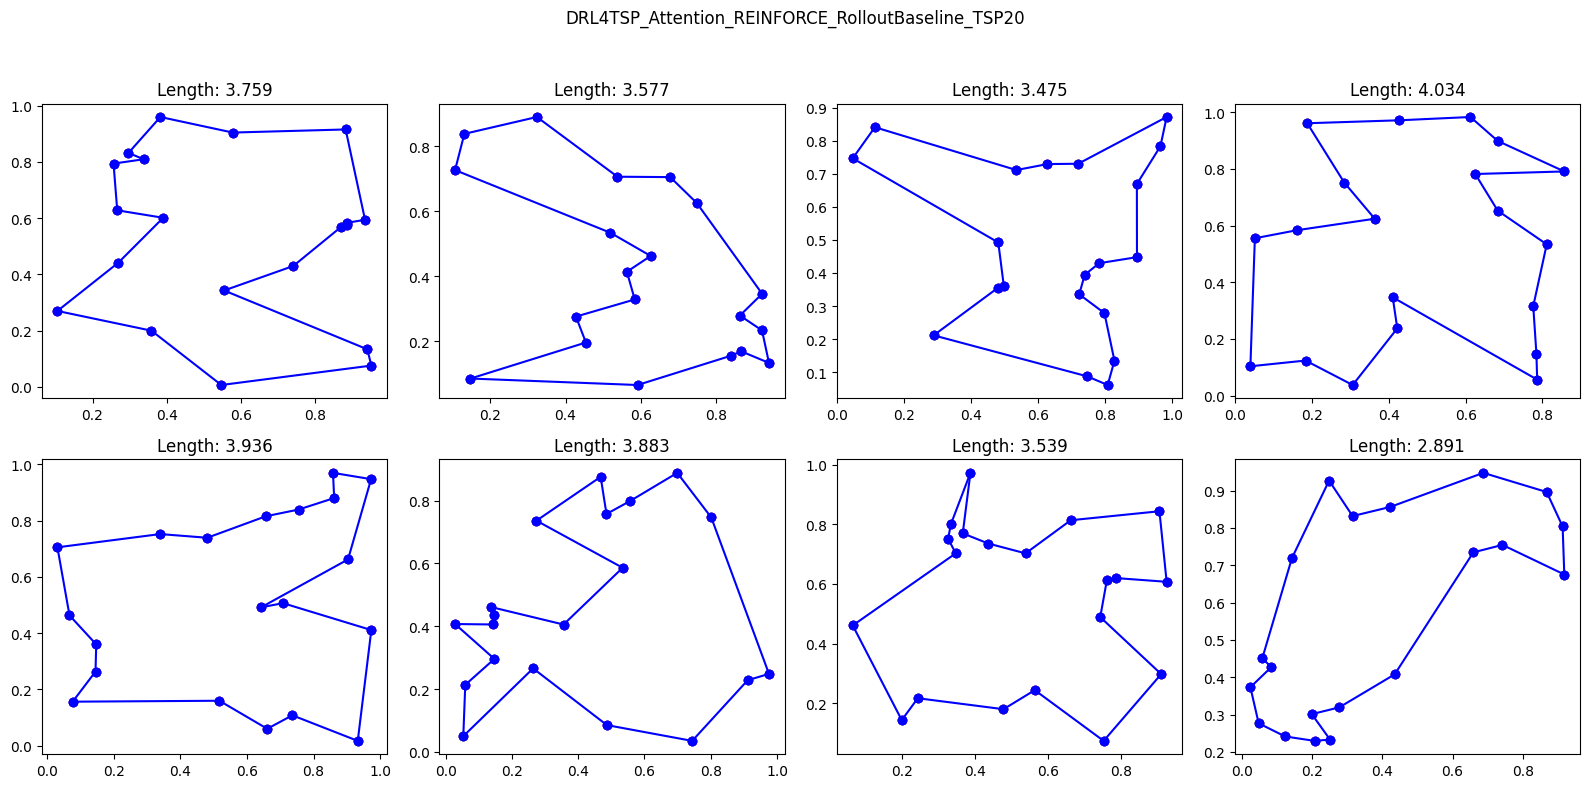

Test average reward: 3.8485
Test completed!


In [21]:
print('Test started...')
test1(args, test_dataset)
print('Test completed!')

In [22]:
# 测试 (sampling)
def sampling(actor, inputs, num_samples, sub_batch_size=1280):
    # inputs: (batch_size, seq_len, input_size)
    batch_size = inputs.size(0)
    best_idxs, best_rewards = [], []
    
    for i in range(batch_size):
        temp_input = inputs[i].unsqueeze(0)
        best_idx, best_reward = None, float('inf')
        
        num_sub_batches = (num_samples + sub_batch_size - 1) // sub_batch_size
        
        remaining_samples = num_samples
        for _ in range(num_sub_batches):
            current_batch_size = min(sub_batch_size, remaining_samples)
            remaining_samples -= current_batch_size
            
            temp_inputs = temp_input.repeat(current_batch_size, 1, 1)
            temp_rewards, temp_idxs, _ = actor(temp_inputs)
            
            sub_best_reward, sub_best_idx = temp_rewards.min(0)
            sub_best_reward = sub_best_reward.item()
            sub_best_idx = temp_idxs[sub_best_idx]
            
            if sub_best_reward < best_reward:
                best_idx = sub_best_idx
                best_reward = sub_best_reward
            
        best_idxs.append(best_idx)
        best_rewards.append(best_reward)
    
    return torch.tensor(best_rewards, device=inputs.device), torch.stack(best_idxs, dim=0).to(inputs.device)
        

def test2(args, test_dataset):
    test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)
    
    actor = Actor(args.num_heads, args.embedding_size, args.num_layers, args.input_size, args.FF_hidden_size, args.normalization, args.dropout, args.C, 2.5, False, reward).to(args.device)
    actor.load_state_dict(torch.load(os.path.join(args.output_dir, args.name)))
    
    actor.eval()
    total_rewards, total_nums = 0, 0
    
    with torch.no_grad():
        for i, test_batch in enumerate(test_loader):
            inputs = test_batch.to(args.device)
            actor_rewards, idxs = sampling(actor, inputs, args.num_samples)
            total_rewards += actor_rewards.sum().item()
            total_nums += inputs.size(0)
            
            if i == 0 and inputs.size(0) >= 8:
                plot_tsp_paths(args, inputs[:8], idxs[:8], actor_rewards[:8])
            
    avg_reward = total_rewards / total_nums
    print(f"Test average reward (sampling): {avg_reward:.4f}")

Test started...


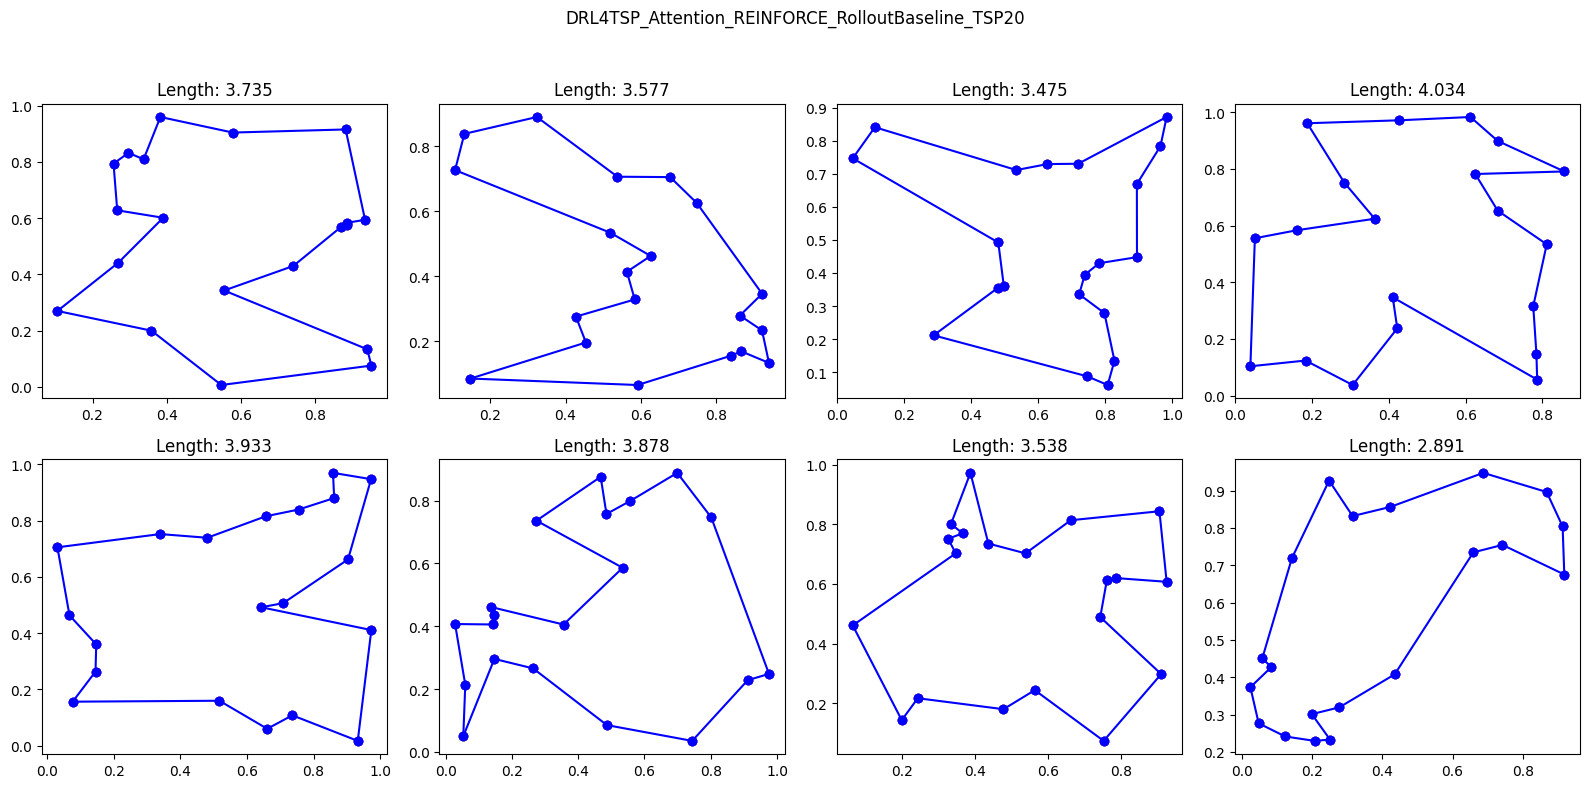

Test average reward (sampling): 3.8321
Test completed!


In [23]:
print('Test started...')
test2(args, test_dataset)
print('Test completed!')